# Identifying Cancer using CNN

## Overview

Identifying cancer by humans is an extremely specialized skill developed over years of experience. Machine learning presents a huge opportunity to make the cancer identification easier and more accurate.

In this notebook we will attempt to develop a convulution neural network to predict the presence of metastatic cancer. 

**The requirements for completion of this project are listed below:**
* Brief description of the problem and data
* Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
* Model Architecture
* Results and Analysis
* Conclusion

## Setup

In the following lines of code I import the packages necessary to perform the following functions:

* Data Inspection
* Data Visualization
* Model Creation
* Model Evaluation

Further, I set up the compute to use CPU/GPU/TPU.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import random
import optuna

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport

from sklearn.utils import shuffle
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import matplotlib.patches as patches


import seaborn as sns
import plotly.express as px



from skimage.transform import rotate
from skimage import io
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from pathlib import Path
from PIL import Image
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)


Setup of the GPU provided by Kaggle. 

In [2]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()
strategy = tf.distribute.get_strategy()

# Data Import and Description

The below group of code imports the training and test data. It also sets the random state for all alogrithms that require reproducibility. 

The training data is very simple with two columns. The first column is the id of the tif file with the cancer screening picture. The second contains the lable of whether cancer is present.

By investigating the first 5 rows we get a good sample of the full dataset.

The full data set contains 220025 images. 130,908 of the images are cancer free. 89,117 of the images have cancer.

By running a Pandas Profile we see that there is no missing. 

After plotting a few of the pictures you can see that without specialized training identifying which picture has cancer is nearly impossible.


In [3]:
#get files
RANDOM_STATE = 49
test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
file_name = '../input/histopathologic-cancer-detection/train_labels.csv'

n = sum(1 for line in open(file_name)) - 1 #number of records in file (excludes header)
s = 220025 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
train_data = pd.read_csv(file_name, dtype=str, skiprows=skip)

#train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv',dtype=str, nrows = 1000)
train_data.id = train_data.id + '.tif'

In [4]:
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


In [6]:
report = ProfileReport(train_data)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
i = train_data.describe()

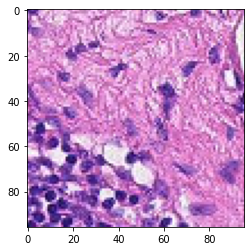

File Name: 8e294a0fe82d36c9ae921ef2cc76ed0d0691b90f.tif Label: 0


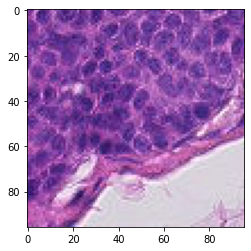

File Name: 8e294a0fe82d36c9ae921ef2cc76ed0d0691b90f.tif Label: 1


In [8]:
# plot few Train images
%matplotlib inline

img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_data.iloc[25,0]}')
imgplot = plt.imshow(img)
plt.show()
print(f'File Name: {train_data.iloc[25,0]} Label: {train_data.iloc[25,1]}')

img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_data.iloc[210,0]}')
imgplot = plt.imshow(img)
plt.show()
print(f'File Name: {train_data.iloc[25,0]} Label: {train_data.iloc[210,1]}')

## Model Architecture

### Data Preperation

The below code snippets creates the trainng and validation sets for use in tensor flow

The parameters that are important to set in the ImageDataGenerator are higlighted in the documentation https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator:

I started with the default settings in the doc and updated during parameter setting.

The parameters that are imporat to set in the datagen.flow_from_dataframe function are highlighted in the documentation https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

For my project I was able to change the target size as a parameter.

In [9]:
# modify training data by normalizing it 
# and split data into training and validation sets
datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.2)

# set model constants
BATCH_SIZE = 256

In [10]:
def read_pil_image(img_path, width, height):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))
        
def load_all_images(dataset_path, height, width, img_ext='tif'):
    return np.array([read_pil_image(str(p), height, width) for p in 
                                    Path(dataset_path).rglob("*."+img_ext)]) 

In [11]:
#datagen.fit(load_all_images(train_path, 64, 64))

In [12]:
# generate training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))

Found 176020 validated image filenames belonging to 2 classes.


In [13]:
# generate validation data
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))

Found 44005 validated image filenames belonging to 2 classes.


In [14]:
train_steps = np.ceil(len(train_generator) / BATCH_SIZE)
val_steps = np.ceil(len(valid_generator) / BATCH_SIZE)

print('Steps:')
print('Train: %d | Validation: %d ' %(train_steps, val_steps))

Steps:
Train: 3 | Validation: 1 


## Model Preperation
The below is where I generate the model.

First choice is using AUC as the model metric to determine the accuracy.

Next choice is to determine how many layers, filters, and kernel size.

I chose layers based upon the accuracy gained with each layer. If there are too many layers performance decreases and overfitting becomes a larger issue.

2022-10-06 12:36:26.758527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 12:36:26.763168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 12:36:26.763979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 12:36:26.765374: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (256, 62, 62, 16)         448       
_________________________________________________________________
conv2d_1 (Conv2D)            (256, 60, 60, 16)         2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (256, 30, 30, 16)         0         
_________________________________________________________________
dropout (Dropout)            (256, 30, 30, 16)         0         
_________________________________________________________________
batch_normalization (BatchNo (256, 30, 30, 16)         64        
_________________________________________________________________
conv2d_2 (Conv2D)            (256, 28, 28, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (256, 26, 26, 32)         9

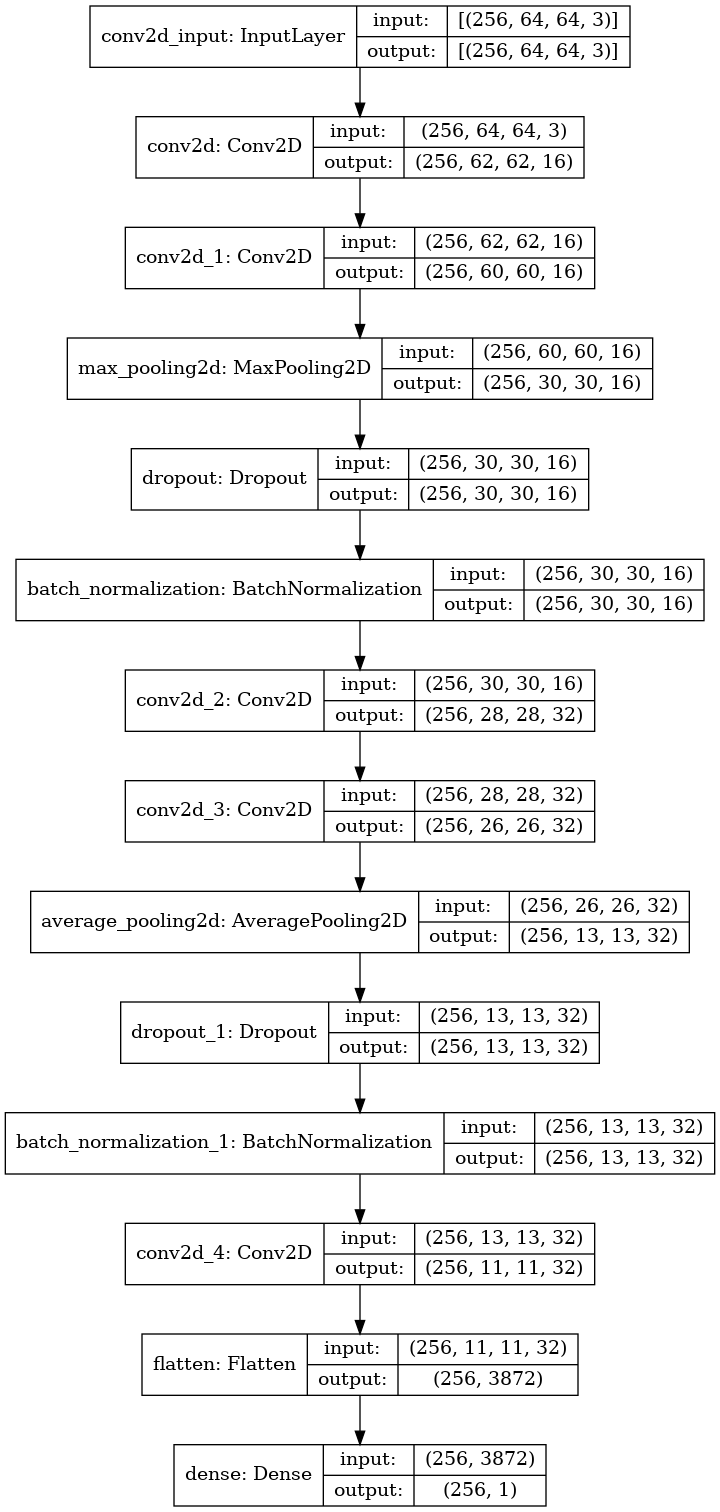

In [15]:

with strategy.scope():

    #create model
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.1))

    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Dropout(0.1))

    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    #build model by input size
    model.build(input_shape=(BATCH_SIZE, 64, 64, 3))       # original image = (96, 96, 3) 

    #compile
    adam_optimizer = Adam(learning_rate=0.0001)
    ROC = tf.keras.metrics.AUC()
    model.compile(loss='binary_crossentropy', metrics=['accuracy', ROC], optimizer=adam_optimizer)

#quick look at model
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
def objective(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    n_layers = trial.suggest_int('n_layers', 1, 3)
    model_2 = tf.keras.Sequential()
    model_2.add(tf.keras.layers.Flatten())
    for i in range(n_layers):
        num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
        model_2.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
    model_2.add(tf.keras.layers.Dense(CLASSES))
    ...
    return accuracy

In [17]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [18]:
EPOCHS = 20

# train the model
history = model.fit(
        train_generator,
        epochs = EPOCHS,
        validation_data = valid_generator)

2022-10-06 12:36:32.219097: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-10-06 12:36:35.329016: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


688/688 [==============================] - 1128s 2s/step - loss: 0.4711 - accuracy: 0.7824 - auc: 0.8508 - val_loss: 0.9734 - val_accuracy: 0.6418 - val_auc: 0.8785
Epoch 2/20
688/688 [==============================] - 378s 549ms/step - loss: 0.4072 - accuracy: 0.8206 - auc: 0.8902 - val_loss: 0.5403 - val_accuracy: 0.7875 - val_auc: 0.8843
Epoch 3/20
688/688 [==============================] - 288s 418ms/step - loss: 0.3884 - accuracy: 0.8302 - auc: 0.9010 - val_loss: 0.6762 - val_accuracy: 0.7449 - val_auc: 0.8876
Epoch 4/20
688/688 [==============================] - 271s 393ms/step - loss: 0.3737 - accuracy: 0.8375 - auc: 0.9091 - val_loss: 0.5534 - val_accuracy: 0.7781 - val_auc: 0.9035
Epoch 5/20
688/688 [==============================] - 293s 426ms/step - loss: 0.3601 - accuracy: 0.8438 - auc: 0.9158 - val_loss: 0.4084 - val_accuracy: 0.8306 - val_auc: 0.9187
Epoch 6/20
688/688 [==============================] - 286s 416ms/step - loss: 0.3449 - accuracy: 0.8517 - auc: 0.9231 - val

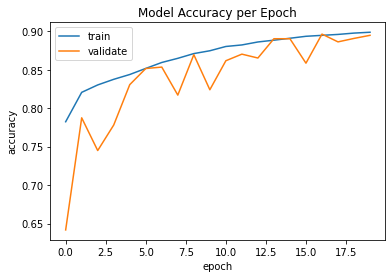

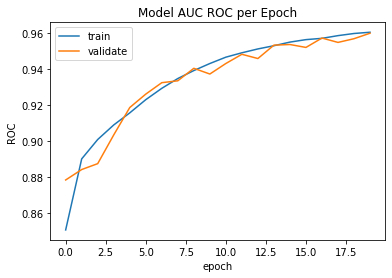

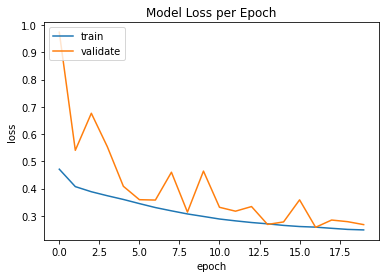

In [19]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();




## Results and Analysis 

As you can see above the mdoel is learning and after 15 epochs the gains are starting to dimnish. 

One very positive outcome is how close the validation and the training accuracy is growing. Further the competition accuracy was very close to what one would expect from validation set.

This observation led to the tightening of hyperparameters that could cause overfitting as well as the increase in epochs.

In [20]:
#create a dataframe to run the predictions
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [21]:

datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [22]:
predictions = model.predict(test_generator, verbose=1)
print(predictions)

57458/57458 [==============================] - 389s 7ms/step
[[0.41241655]
 [0.20388673]
 [0.04415748]
 ...
 [0.98484564]
 [0.01095449]
 [0.12677215]]


In [23]:
#create submission dataframe
print(predictions)
predictions = np.transpose(predictions)[0]
print(predictions)
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

[[0.41241655]
 [0.20388673]
 [0.04415748]
 ...
 [0.98484564]
 [0.01095449]
 [0.12677215]]
[0.41241655 0.20388673 0.04415748 ... 0.98484564 0.01095449 0.12677215]


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1


In [24]:
report = ProfileReport(submission_df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
#view test prediction counts
submission_df['label'].value_counts()

0    34709
1    22749
Name: label, dtype: int64

In [26]:
#convert to csv to submit to competition
submission_df.to_csv('submission.csv', index=False)

## Conclusion

To be able to see the difference that machine learning can make on such an important area of study is extremely empowering.

The major improvement to this project that I would make is utilizing a hyperparameter optimizer like keras_tuner.

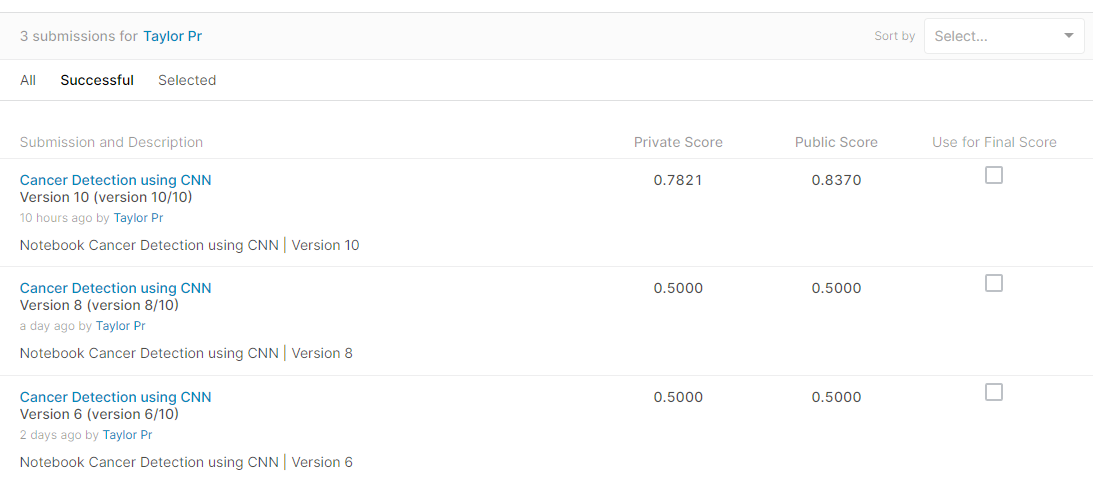